In [4]:
import json
import numpy as np
import pandas as pd
import os
import math
import pickle
import tqdm

In [5]:
def load_scores_(mat_path, n_queries):
    mat = np.fromfile(mat_path, dtype=np.float32)[4:]
    n_targets = len(mat) // n_queries
    return mat.reshape(n_queries, n_targets)    

In [6]:
def load_files_(expected_rows, mat_path, features_path):
    features = json.load(open(features_path))
    mat = load_scores_(mat_path, expected_rows)
    np.fill_diagonal(mat, mat.min() - 1) # self dist is not interesting!
    prob_ids = np.array(features['id'])
    return mat, prob_ids

In [7]:
def load_scores(mat_path, matches_path):
    n_queries = len(json.load(open(matches_path)))
    mat = np.fromfile(mat_path, dtype=np.float32)[4:]
    n_targets = len(mat) // n_queries
    return mat.reshape(n_queries, n_targets)    

In [8]:
def load_files(match_path, distractor_mat_path, prob_mat_path, prob_features_path, dist_features_path):
    prob_features = json.load(open(features_path))
    dist_features = json.load(open(dist_features_path))
    distractor_mat = load_scores(distractor_mat_path, match_path)
    prob_mat = load_scores(prob_mat_path, match_path)
    np.fill_diagonal(prob_mat, prob_mat.min() - 1) # self dist is not interesting!
    prob_ids = np.array(prob_features['id'] + dist_features['id'])
    return prob_mat, distractor_mat, prob_ids

In [9]:
def dist_fuse(mat_1, mat_2):
    return (mat_1 + mat_2) / 2

In [10]:
def top1(prob_mat, distractor_mat, prob_ids):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat and distmat entries
    """
    
    #out_max = np.max(distractor_mat, axis=1) # best out of distractor set
    #out_max_labels = np.argmax(distractor_mat, axis=1) # best out of distractor set
    
    np.fill_diagonal(prob_mat, prob_mat.min() - 1)
    tot_mat = np.concatenate((prob_mat, distractor_mat), axis=1) # working with a small matrix :)
    
    top_scores = np.max(tot_mat, axis=1)
    top_labels = np.argmax(tot_mat, axis=1) # indices
    top_labels = prob_ids[top_labels]
    
    return top_labels, top_scores

In [11]:
def topk(prob_mat, distractor_mat, prob_ids, k):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat entries
    """
    
    tot_mat = np.concatenate((prob_mat, distractor_mat), axis=1) # working with a small matrix :)
    out_max_k = -np.partition(-tot_mat, k, axis=1)[:, :k] # best out of distractor set
    out_max_labels_k = np.argpartition(-tot_mat, k, axis=1)[:, :k] # best out of distractor set
    out_max_labels_k = prob_ids[out_max_labels_k]
    
    return out_max_labels_k, out_max_k

In [12]:
def rank1_(prob_mat, distractor_mat, prob_ids):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat entries
    """
    
    out_max = np.max(distractor_mat, axis=1) # best out of distractor set
    tot_mat = np.concatenate((prob_mat, out_max.reshape((prob_mat.shape[0], 1))), axis=1) # working with a small matrix :)
    n_probs = prob_mat.shape[1]
    inf_ = tot_mat.min() - 1
    score = 0
    n_query = 0 
    for query_id in set(prob_ids[:prob_mat.shape[0]]):
        # probes from iden
        row_mask = list((query_id == prob_ids[:prob_mat.shape[0]]))
        curr_id_mat = tot_mat[row_mask, :]
        
        n_id_probs, n_probs_and_one_other = curr_id_mat.shape
        query_indices = np.argwhere(row_mask).T[0]
        for row_i, col_i in enumerate(query_indices):
            # nullify all other cols from indices
            col_mask = row_mask.copy()
            col_mask[col_i] = False
            col_mask.append(False)

            other_probs_sub = curr_id_mat[: , col_mask].copy()
            curr_id_mat[: , col_mask] = inf_

            # calc hits
            top_hits = np.delete(np.argmax(curr_id_mat, axis=1), row_i ,0)
            top_id = prob_ids[top_hits]
            score += sum(top_id == query_id)
            n_query += len(top_id)

            # get them back
            curr_id_mat[:, col_mask] = other_probs_sub
            
    return score/n_query

In [13]:
def open_set_label_and_score(prob_mat, distractor_mat, prob_ids):
    """
         What is the 2nd iden for the prob if he is not in set?
         What is it's score?
    """
    
    indexes = np.unique(prob_ids[:prob_mat.shape[0]], return_index=True)[1]  # ids sorted by apperance
    id_set = [prob_ids[:prob_mat.shape[0]][index] for index in sorted(indexes)]
    res_label = []
    res_score = []
    inf_ = min(distractor_mat.min(), prob_mat.min()) - 1
    for curr_id in id_set:
        # nullify all query cols from indices
        row_mask = list((curr_id == prob_ids[:prob_mat.shape[0]]))
        curr_prob_mat = prob_mat[row_mask, :].copy()
        curr_prob_mat[: , row_mask] = inf_
        
        label, scores = top1(curr_prob_mat, distractor_mat[row_mask, :], prob_ids)
        res_label.extend(label)
        res_score.extend(scores)
    return np.array(res_label), np.array(res_score)

In [14]:
def open_set_label_and_score_topk(prob_mat, distractor_mat, prob_ids):
    """
         What is the 2nd iden for the prob if he is not in set?
         What is it's score?
    """
    
    indexes = np.unique(prob_ids[:prob_mat.shape[0]], return_index=True)[1]  # ids sorted by apperance
    id_set = [prob_ids[:prob_mat.shape[0]][index] for index in sorted(indexes)]
    res_label = []
    res_score = []
    inf_ = min(distractor_mat.min(), prob_mat.min()) - 1
    for curr_id in id_set:
        # nullify all query cols from indices
        row_mask = list((curr_id == prob_ids[:prob_mat.shape[0]]))
        curr_prob_mat = prob_mat[row_mask, :].copy()
        curr_prob_mat[: , row_mask] = inf_
        
        label, scores = topk(curr_prob_mat, distractor_mat[row_mask, :], prob_ids, 3)
        res_label.append(label)
        res_score.append(scores)
    return np.vstack(res_label), np.vstack(res_score)

In [15]:
def model_agreement(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids):
    open_set_k_labels_0, open_set_k_scores_0  = open_set_label_and_score_topk(prob_mat_0, distractor_mat_0, prob_ids)
    open_set_k_labels_1, open_set_k_scores_1 = open_set_label_and_score_topk(prob_mat_1, distractor_mat_1, prob_ids)

    a = 0
    for row_0, row_1 in zip(open_set_k_labels_0, open_set_k_labels_1):
        a+= (len(np.intersect1d(row_0, row_1)) > 0)
    b = len(prob_ids)
    print('\n any(2nd,3rd,4th) iden Corr=%0.1f%% \n' % (100.0*a / b) )

In [16]:
def agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids):
    #print('Agreement model')
    top1_labels_0, top1_scores_0 = top1(prob_mat_0, distractor_mat_0, prob_ids)
    top1_labels_1, top1_scores_1 = top1(prob_mat_1, distractor_mat_1, prob_ids)

    open_set_1st_labels_0, open_set_1st_scores_0  = open_set_label_and_score(prob_mat_0, distractor_mat_0, prob_ids)
    open_set_1st_labels_1, open_set_1st_scores_1 = open_set_label_and_score(prob_mat_1, distractor_mat_1, prob_ids)
    
    a = np.sum((open_set_1st_labels_0 == open_set_1st_labels_1))
    b = prob_mat_0.shape[0]
    corr = (100.0*a / b)
    #print('2nd iden Corr=%0.1f%%' % corr )

    target_FTRS = [0.001, 0.01, 0.1, 0.2, 0.3]
    thresholds = np.unique(np.concatenate((top1_scores_0,top1_scores_1,
                                              open_set_1st_scores_0,open_set_1st_scores_1)))

    models_agree = (open_set_1st_labels_0 == open_set_1st_labels_1)
    FTRs = [np.sum(models_agree & (open_set_1st_scores_0 > TH) & (open_set_1st_scores_1 > TH)) / b
            for TH in thresholds]
    
    mod_0_corr = (top1_labels_0 == prob_ids[:prob_mat_0.shape[0]])
    mod_1_corr = (top1_labels_1 == prob_ids[:prob_mat_0.shape[0]])
    TTRs = [np.sum( (top1_scores_0 > TH) &
                    (top1_scores_1 > TH) &
                     mod_0_corr &
                     mod_1_corr ) / b for TH, FTR in zip(thresholds, FTRs)]

    target_TTRs = []
    for target_FTR in target_FTRS:
        if (FTRs[0] <= target_FTR):
            #print('FTR=%0.1f%%, TTR=%0.1f%%' % (target_FTR * 100, TTRs[0] * 100))
            target_TTRs.append(TTRs[0])
            continue
        for TH, FTR, TTR in zip(thresholds, FTRs, TTRs):
            if math.isclose(FTR, target_FTR, abs_tol = 0.001):
                #print('FTR=%0.1f%%, TTR=%0.1f%%' % (FTR * 100, TTR * 100))
                target_TTRs.append(TTR)
                break
        
    return np.array(thresholds), np.array(FTRs), np.array(TTRs), np.array(target_TTRs), corr

In [17]:
def dist_fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids):
    #print('\nDist_fuse model')
    rank1_0 = rank1_(prob_mat_0, distractor_mat_0, prob_ids)
    rank1_1 = rank1_(prob_mat_1, distractor_mat_1, prob_ids)
    prob_mat = dist_fuse(prob_mat_0,prob_mat_1)
    distractor_mat = dist_fuse(distractor_mat_0, distractor_mat_1)
    rank1_fuse = rank1_(prob_mat, distractor_mat, prob_ids)
    
    #print('Rank-1:\n model0:{} \n model1:{} \n mean_fuse:{}'.format(rank1_0, rank1_1, rank1_fuse))
    
    top1_labels, top1_scores = top1(prob_mat, distractor_mat, prob_ids)
    open_set_1st_labels, open_set_1st_scores = open_set_label_and_score(prob_mat, distractor_mat, prob_ids)

    target_FTRS = [0.001, 0.01, 0.1, 0.2, 0.3]
    thresholds = np.unique(np.concatenate((top1_scores, open_set_1st_scores)))

    FTRs = [np.sum((open_set_1st_scores > TH)) / prob_mat.shape[0] for TH in thresholds]
    mod_corr = (top1_labels == prob_ids[:prob_mat_0.shape[0]])
    TTRs = [np.sum( (top1_scores > TH) &
                     mod_corr) / prob_mat.shape[0] for TH, FTR in zip(thresholds, FTRs)]

    target_TTRs = []
    for target_FTR in target_FTRS:
        if (FTRs[0] <= target_FTR):
            #print('FTR=%0.1f%%, TTR=%0.1f%%' % (target_FTR * 100, TTRs[0] * 100))
            target_TTRs.append(TTRs[0])
            continue
        for TH, FTR, TTR in zip(thresholds, FTRs, TTRs):
            if math.isclose(FTR, target_FTR, abs_tol = 0.001):
                #print('FTR=%0.1f%%, TTR=%0.1f%%' % (FTR * 100, TTR * 100))
                target_TTRs.append(TTR)
                break
        
    return np.array(thresholds), np.array(FTRs), np.array(TTRs), rank1_fuse, np.array(target_TTRs)

In [18]:
def get_verification(cmc_path, idx):
    cmc = json.load(open(cmc_path))
    for TH, acc in zip(*cmc['roc']):
        if math.isclose(TH, 1e-6, abs_tol = 1e-6) and TH > 1e-6:
            print('Verification %d: %0.4f%%' % (idx, acc))
            break

In [26]:
def get_ranks(name_dir, sample=0):
    # load data
    mat_path = "results_lfw/"+name_dir+"/"+name_dir+"_0/otherFiles/lfw_lfw_"+name_dir+"_0.bin"
    features_path = "results_lfw/"+name_dir+"/"+name_dir+"_0/otherFiles/lfw_features_"+name_dir+"_0"
    mat_0, prob_ids_tot = load_files_(expected_rows, mat_path, features_path)

    if 'morph' in name_dir:
        mat_path = "results_lfw/morph0.01/morph0.01_2020/otherFiles/lfw_lfw_morph0.01_2020.bin"
        features_path = "results_lfw/morph0.01/morph0.01_2020/otherFiles/lfw_features_morph0.01_2020"
        mat_1, _ = load_files_(expected_rows, mat_path, features_path)
    else:
        mat_path = "results_lfw/"+name_dir+"/"+name_dir+"_1/otherFiles/lfw_lfw_"+name_dir+"_1.bin"
        features_path = "results_lfw/"+name_dir+"/"+name_dir+"_1/otherFiles/lfw_features_"+name_dir+"_1"
        mat_1, _ = load_files_(expected_rows, mat_path, features_path)

    # filter probes to rows with more then one iden
    ids, counts = np.unique(prob_ids_tot, return_counts=True)
    prob_ids_mask = np.isin(prob_ids_tot, ids[counts>1])
    prob_ids_ = prob_ids_tot[prob_ids_mask]
    dist_ids_ = prob_ids_tot[~prob_ids_mask]
    prob_ids = np.concatenate((prob_ids_, dist_ids_))
    prob_mat_0 = mat_0[prob_ids_mask][:, prob_ids_mask]
    distractor_mat_0 = mat_0[prob_ids_mask][:, ~prob_ids_mask]
    prob_mat_1 = mat_1[prob_ids_mask][:, prob_ids_mask]
    distractor_mat_1 = mat_1[prob_ids_mask][:, ~prob_ids_mask]
    
    rank1_0 = rank1_(prob_mat_0, distractor_mat_0, prob_ids)
    rank1_1 = rank1_(prob_mat_1, distractor_mat_1, prob_ids)
    return rank1_0, rank1_1

In [19]:
def get_results(name_dir, sample=0):
    # load data
    mat_path = "results_lfw/"+name_dir+"/"+name_dir+"_0/otherFiles/lfw_lfw_"+name_dir+"_0.bin"
    features_path = "results_lfw/"+name_dir+"/"+name_dir+"_0/otherFiles/lfw_features_"+name_dir+"_0"
    mat_0, prob_ids_tot = load_files_(expected_rows, mat_path, features_path)

    if 'morph' in name_dir:
        mat_path = "results_lfw/morph0.01/morph0.01_2020/otherFiles/lfw_lfw_morph0.01_2020.bin"
        features_path = "results_lfw/morph0.01/morph0.01_2020/otherFiles/lfw_features_morph0.01_2020"
        mat_1, _ = load_files_(expected_rows, mat_path, features_path)
    else:
        mat_path = "results_lfw/"+name_dir+"/"+name_dir+"_1/otherFiles/lfw_lfw_"+name_dir+"_1.bin"
        features_path = "results_lfw/"+name_dir+"/"+name_dir+"_1/otherFiles/lfw_features_"+name_dir+"_1"
        mat_1, _ = load_files_(expected_rows, mat_path, features_path)

    # filter probes to rows with more then one iden
    ids, counts = np.unique(prob_ids_tot, return_counts=True)
    prob_ids_mask = np.isin(prob_ids_tot, ids[counts>1])
    prob_ids_ = prob_ids_tot[prob_ids_mask]
    dist_ids_ = prob_ids_tot[~prob_ids_mask]
    prob_ids = np.concatenate((prob_ids_, dist_ids_))
    prob_mat_0 = mat_0[prob_ids_mask][:, prob_ids_mask]
    distractor_mat_0 = mat_0[prob_ids_mask][:, ~prob_ids_mask]
    prob_mat_1 = mat_1[prob_ids_mask][:, prob_ids_mask]
    distractor_mat_1 = mat_1[prob_ids_mask][:, ~prob_ids_mask]

    if sample>0:
        # for each iden - sample at most 4 images
        get_samples = lambda x: x.values.T[0] if len(x) < sample else x.sample(n=sample, replace=False).values.T[0]
        name_over_ind = pd.DataFrame(prob_ids_).reset_index().set_index(0).rename(columns={'index':'ind'}).groupby(0)
        sampled_indices = np.hstack(name_over_ind.apply(lambda x: get_samples(x)).values.tolist())
        sampled_ids = name_over_ind.apply(lambda x: get_samples(x)).index.tolist()
        prob_mat_0 = prob_mat_0[sampled_indices][:, sampled_indices]
        distractor_mat_0 = distractor_mat_0[sampled_indices]
        prob_mat_1 = prob_mat_1[sampled_indices][:, sampled_indices]
        distractor_mat_1 = distractor_mat_1[sampled_indices]
        prob_ids = np.concatenate((prob_ids_[sampled_indices], dist_ids_))
    
    # send to calc
    res = dict()
    thresholds, FTRs, TTR, target_TTRs, corr = agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
    fuse_thresholds, fuse_FTRs, fuse_TTR, rank1_fuse, fuse_target_TTRs = dist_fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
    res['corr'] = corr
    res['thresholds'] = thresholds
    res['FTRs'] = FTRs
    res['TTR'] = TTR
    res['target_TTRs'] = target_TTRs
    res['fuse_thresholds'] = fuse_thresholds
    res['fuse_FTRs'] = fuse_FTRs
    res['fuse_TTR'] = fuse_TTR
    res['rank1_fuse'] = rank1_fuse
    res['fuse_target_TTRs'] = fuse_target_TTRs
    return res

In [27]:
expected_rows = 13183
res_collection = dict()

In [37]:
score_dirs = ['baseline', 
              'pearson_.9', 'pearson_.75', 'pearson_.5', 'pearson_.25', 'pearson_.1',
              'mean_.9', 'mean_.75', 'mean_.5', 'mean_.25', 'mean_.1',
              'ncl', 'morph0.1', 'morph0.05', 'morph0.01']

In [ ]:
for name_dir in tqdm.tqdm_notebook(score_dirs, total=len(score_dirs), desc=str(i)):
    res_collection[name_dir] = get_results(name_dir)#, sample=4)
    pickle.dump(res_collection[name_dir], open('results_lfw/res_'+str(i)+'_'+name_dir+'.pkl', 'wb'))

In [38]:
# for i in range(1):
for name_dir in tqdm.tqdm_notebook(score_dirs, total=len(score_dirs), desc='wow'):
    res_collection[name_dir] = dict()
    res_collection[name_dir]['rank_0'], res_collection[name_dir]['rank_1'] = get_ranks(name_dir)#, sample=4)
    # pickle.dump(res_collection[name_dir], open('results_lfw/res_'+str(i)+'_'+name_dir+'.pkl', 'wb'))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [45]:
pd.options.display.float_format = '{:.3f}'.format

print((pd.DataFrame.from_dict(res_collection)[['baseline', 'ncl', 'mean_.1', 'mean_.25', 'mean_.5', 'mean_.75', 'mean_.9', 'morph0.01', 'morph0.05', 'morph0.1', 'pearson_.1', 'pearson_.25', 'pearson_.5', 'pearson_.75', 'pearson_.9']]*100).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &  baseline &    ncl &  mean\_.1 &  mean\_.25 &  mean\_.5 &  mean\_.75 &  mean\_.9 &  morph0.01 &  morph0.05 &  morph0.1 &  pearson\_.1 &  pearson\_.25 &  pearson\_.5 &  pearson\_.75 &  pearson\_.9 \\
\midrule
rank\_0 &    99.806 & 99.802 &   99.800 &    99.802 &   99.731 &    99.802 &   99.731 &     99.712 &     99.741 &    99.644 &      99.799 &       99.773 &      99.783 &       99.638 &      99.370 \\
rank\_1 &    99.818 & 99.794 &   99.796 &    99.763 &   99.701 &    99.763 &   99.701 &     99.813 &     99.813 &    99.813 &      99.800 &       99.812 &      99.769 &       99.740 &      99.571 \\
\bottomrule
\end{tabular}



In [33]:
pd.DataFrame.to_dict(res_collection)

AttributeError: 'dict' object has no attribute 'columns'

In [22]:
# load res
for name_dir in score_dirs:
    print(name_dir)
    res_collection[name_dir] = pickle.load(open('results_lfw/res_9_'+name_dir+'.pkl', 'rb'))

baseline
pearson_.9
pearson_.75
pearson_.5
pearson_.25
pearson_.1
mean_.9
mean_.75
mean_.5
mean_.25
mean_.1
ncl
morph0.1
morph0.05
morph0.01


In [67]:
# load res
for name_dir in score_dirs:
    print(name_dir)
    res_collection[name_dir]= dict()
    for i in range(10):
        res_collection[name_dir][i] = pickle.load(open('results_lfw/sample4_mean_'+str(i)+'_'+name_dir+'.pkl', 'rb'))

baseline
pearson_.9
pearson_.75
pearson_.5
pearson_.25
pearson_.1
mean_.9
mean_.75
mean_.5
mean_.25
mean_.1
ncl
morph0.1
morph0.05
morph0.01


In [20]:
# get res
target_FTRS = [0.001, 0.01, 0.1, 0.2, 0.3]

for attr in ['rank1_fuse', 'fuse_target_TTRs', 'target_TTRs', 'corr']:
    res_collection[attr] = pd.DataFrame(np.vstack(
        [np.mean([res_collection[name_dir][i][attr] for i in range(10)], axis=0)] for name_dir in score_dirs),
                                       index=score_dirs, columns=target_FTRS if 'TTRs' in attr else [attr])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


KeyError: 0

In [64]:
res_collection['rank1_fuse'].sort_values('rank1_fuse')

,rank1_fuse
pearson_.9,0.986405
morph0.1,0.987994
morph0.01,0.988467
pearson_.75,0.988884
mean_.1,0.989063
mean_.5,0.989130
pearson_.1,0.989423
morph0.05,0.989423
baseline,0.989489
pearson_.25,0.989536


In [54]:
res_collection['corr'].sort_values('corr')

,corr
mean_.9,10.789854
mean_.5,10.983708
pearson_.9,12.734584
pearson_.75,19.010105
mean_.25,26.584863
mean_.75,26.665292
pearson_.5,29.406063
morph0.1,33.689420
morph0.01,33.994638
pearson_.25,35.017529


In [63]:
res_collection['target_TTRs']

,0.001,0.01,0.1,0.2,0.3
baseline,0.410827,0.979027,0.991173,0.991462,0.992122
pearson_.9,0.397072,0.970138,0.987791,0.987833,0.987833
pearson_.75,0.343514,0.974551,0.990349,0.990431,0.990431
pearson_.5,0.388596,0.976923,0.990080,0.990740,0.990988
pearson_.25,0.407919,0.977583,0.989812,0.990720,0.991173
pearson_.1,0.408600,0.977088,0.991091,0.991545,0.991978
mean_.9,0.413570,0.974758,0.989256,0.989359,0.989359
mean_.75,0.386306,0.978181,0.990431,0.991050,0.991256
mean_.5,0.399237,0.972427,0.989214,0.989359,0.989359
mean_.25,0.386925,0.976243,0.990555,0.991173,0.991380


In [78]:
res_collection['fuse_target_TTRs'].sort_values(0.01)*100

,0.001,0.01,0.1,0.2,0.3
morph0.05,39.168901,97.341720,99.168901,99.195710,99.195710
morph0.01,40.624871,97.413900,99.137967,99.158589,99.179212
pearson_.9,39.686533,97.514952,99.010105,99.036915,99.041039
pearson_.75,37.865539,97.636626,99.181274,99.232832,99.243143
mean_.5,35.782636,97.657249,99.208084,99.224582,99.224582
mean_.25,39.533925,97.657249,99.216333,99.259641,99.259641
mean_.1,36.186843,97.756238,99.076098,99.179212,99.212209
pearson_.1,40.204166,97.807795,99.164776,99.199835,99.208084
morph0.1,36.704475,97.826356,99.179212,99.203960,99.203960
mean_.75,38.748196,97.882038,99.206022,99.251392,99.251392


In [44]:
def getTTRs(target_FTR = 0.001):
    target_TTRs = []
    for ind in res_table.index:
        FTRs = res_table['FTRs'][ind]
        TTRs = res_table['TTR'][ind]
        if (FTRs[0] <= target_FTR):
            #print('FTR=%0.5f%%, TTR=%0.1f%%' % (target_FTR, TTRs[0] * 100))
            target_TTRs.append(TTRs[0])
            continue
        for FTR, TTR in zip(FTRs, TTRs):
            if math.isclose(FTR, target_FTR, abs_tol = 0.001):
                #print('FTR=%0.5f%%, TTR=%0.1f%%' % (FTR, TTR * 100))
                target_TTRs.append(TTR)
                break
    return target_TTRs

In [91]:
FTRS_table[0.03] = getTTRs(0.03)

In [71]:
for TH in np.arange(1e-3, 1e-2, 1e-3):
    FTRS_table[TH] = getTTRs(TH)

In [66]:
np.arange(1e-3, 1e-2, 1e-3)

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])

In [70]:
res_table = pd.DataFrame.from_dict(res_collection, 'index')
FTRS_table =pd.DataFrame(res_table['target_TTRs'].values.tolist(), index=res_table['target_TTRs'].index, columns=target_FTRS)

In [95]:
FTRS_table['rank1_fuse'] = res_table['rank1_fuse']
FTRS_table['corr'] = res_table['corr'] / 100

In [34]:
pd.options.display.float_format = '{:.3f}'.format
print((FTRS_table[['corr', 'rank1_fuse', 0.001, 0.01, 0.1]] * 100 ).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &   corr &  rank1\_fuse &  0.001 &   0.01 &    0.1 \\
\midrule
baseline    & 44.633 &      99.834 & 62.283 & 98.260 & 99.453 \\
mean\_.1     & 39.818 &      99.828 & 62.425 & 98.216 & 99.387 \\
mean\_.25    & 31.360 &      99.837 & 64.985 & 98.074 & 99.409 \\
mean\_.5     & 14.301 &      99.814 & 64.241 & 98.173 & 99.311 \\
mean\_.75    & 31.360 &      99.837 & 64.985 & 98.074 & 99.409 \\
mean\_.9     & 14.301 &      99.814 & 64.241 & 98.173 & 99.311 \\
morph0.01   & 39.151 &      99.812 & 63.891 & 98.567 & 99.387 \\
morph0.05   & 40.748 &      99.822 & 64.230 & 98.479 & 99.453 \\
morph0.1    & 37.991 &      99.800 & 59.908 & 98.490 & 99.387 \\
ncl         & 43.320 &      99.824 & 62.611 & 98.413 & 99.398 \\
pearson\_.1  & 42.138 &      99.826 & 63.399 & 98.501 & 99.453 \\
pearson\_.25 & 39.512 &      99.832 & 64.219 & 98.468 & 99.398 \\
pearson\_.5  & 33.789 &      99.815 & 61.276 & 98.457 & 99.333 \\
pearson\_.75 & 24.642 &      99.789 & 58.190 & 9

In [122]:
print((FTRS_table[['rank1_fuse', 'corr', 1e-2, 5e-3]].T * 100).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
group & baseline & \multicolumn{5}{l}{mean} & \multicolumn{3}{l}{morph} &    ncl & \multicolumn{5}{l}{pearson} \\
{} & baseline & mean\_.1 & mean\_.25 & mean\_.5 & mean\_.75 & mean\_.9 & morph0.01 & morph0.05 & morph0.1 &    ncl & pearson\_.1 & pearson\_.25 & pearson\_.5 & pearson\_.75 & pearson\_.9 \\
\midrule
rank1\_fuse &   99.834 &  99.828 &   99.837 &  99.814 &   99.837 &  99.814 &    99.812 &    99.822 &   99.800 & 99.824 &     99.826 &      99.832 &     99.815 &      99.789 &     99.707 \\
corr       &   44.633 &  39.818 &   31.360 &  14.301 &   31.360 &  14.301 &    39.151 &    40.748 &   37.991 & 43.320 &     42.138 &      39.512 &     33.789 &      24.642 &     17.551 \\
0.01       &   98.260 &  98.216 &   98.074 &  98.173 &   98.074 &  98.173 &    98.567 &    98.479 &   98.490 & 98.413 &     98.501 &      98.468 &     98.457 &      97.965 &     97.483 \\
0.005      &   83.335 &  84.112 &   83.379 &  83.696 &   83.379 &  83.696 &    

In [113]:
FTRS_table['group'] = FTRS_table.index.str.extract('([A-Z, a-z]+)').values

In [119]:
FTRS_table.index = pd.MultiIndex.from_arrays([FTRS_table['group'],FTRS_table.index])

In [120]:
FTRS_table

0.001  0.01   0.1   0.2   0.3  0.002  0.003  0.004  \
group                                                                      
baseline baseline     0.623 0.983 0.995 0.995 0.995  0.677  0.722  0.772   
mean     mean_.1      0.624 0.982 0.994 0.994 0.995  0.690  0.722  0.801   
         mean_.25     0.650 0.981 0.994 0.994 0.995  0.728  0.777  0.809   
         mean_.5      0.642 0.982 0.993 0.994 0.994  0.675  0.726  0.771   
         mean_.75     0.650 0.981 0.994 0.994 0.995  0.728  0.777  0.809   
         mean_.9      0.642 0.982 0.993 0.994 0.994  0.675  0.726  0.771   
morph    morph0.01    0.639 0.986 0.994 0.994 0.995  0.703  0.739  0.788   
         morph0.05    0.642 0.985 0.995 0.995 0.995  0.696  0.743  0.796   
         morph0.1     0.599 0.985 0.994 0.994 0.995  0.683  0.726  0.784   
ncl      ncl          0.626 0.984 0.994 0.995 0.995  0.697  0.756  0.787   
pearson  pearson_.1   0.634 0.985 0.995 0.995 0.995  0.686  0.737  0.765   
         pearson_.25  0.642 0.985 0.994 0.994 0.994  0.724  0.767  0.787   
         pearson_.5   0.613 0.985 0.993 0.994 0.995  0.694  0.716  0.765   
         pearson_.75  0.582 0.980 0.994 0.994 0.994  0.652  0.709  0.790   
         pearson_.9   0.640 0.975 0.991 0.993 0.993  0.717  0.755  0.806   

                      0.005  0.006  0.007  0.008  0.009000000000000001  0.05  \
group                                                                          
baseline baseline     0.833  0.885  0.915  0.948                 0.972 0.994   
mean     mean_.1      0.841  0.890  0.908  0.937                 0.975 0.993   
         mean_.25     0.834  0.884  0.912  0.958                 0.977 0.993   
         mean_.5      0.837  0.894  0.913  0.959                 0.973 0.992   
         mean_.75     0.834  0.884  0.912  0.958                 0.977 0.993   
         mean_.9      0.837  0.894  0.913  0.959                 0.973 0.992   
morph    morph0.01    0.850  0.905  0.920  0.951                 0.971 0.993   
         morph0.05    0.846  0.894  0.929  0.953                 0.975 0.993   
         morph0.1     0.845  0.899  0.924  0.949                 0.979 0.993   
ncl      ncl          0.857  0.886  0.928  0.954                 0.974 0.993   
pearson  pearson_.1   0.831  0.883  0.923  0.945                 0.980 0.994   
         pearson_.25  0.856  0.906  0.919  0.954                 0.974 0.993   
         pearson_.5   0.846  0.897  0.916  0.952                 0.975 0.992   
         pearson_.75  0.840  0.894  0.921  0.963                 0.973 0.993   
         pearson_.9   0.864  0.917  0.931  0.956                 0.971 0.990   

                      0.02  0.03  rank1_fuse  corr     group  
group                                                         
baseline baseline    0.991 0.993       0.998 0.446  baseline  
mean     mean_.1     0.991 0.992       0.998 0.398      mean  
         mean_.25    0.991 0.992       0.998 0.314      mean  
         mean_.5     0.989 0.991       0.998 0.143      mean  
         mean_.75    0.991 0.992       0.998 0.314      mean  
         mean_.9     0.989 0.991       0.998 0.143      mean  
morph    morph0.01   0.990 0.992       0.998 0.392     morph  
         morph0.05   0.990 0.991       0.998 0.407     morph  
         morph0.1    0.990 0.991       0.998 0.380     morph  
ncl      ncl         0.992 0.993       0.998 0.433       ncl  
pearson  pearson_.1  0.991 0.993       0.998 0.421   pearson  
         pearson_.25 0.991 0.992       0.998 0.395   pearson  
         pearson_.5  0.990 0.992       0.998 0.338   pearson  
         pearson_.75 0.989 0.991       0.998 0.246   pearson  
         pearson_.9  0.984 0.987       0.997 0.176   pearson

In [99]:
print((FTRS_table[['rank1_fuse', 'corr', 1e-2, 5e-3]].T * 100 ).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &  baseline &  mean\_.1 &  mean\_.25 &  mean\_.5 &  mean\_.75 &  mean\_.9 &  morph0.01 &  morph0.05 &  morph0.1 &    ncl &  pearson\_.1 &  pearson\_.25 &  pearson\_.5 &  pearson\_.75 &  pearson\_.9 \\
\midrule
rank1\_fuse &    99.834 &   99.828 &    99.837 &   99.814 &    99.837 &   99.814 &     99.812 &     99.822 &    99.800 & 99.824 &      99.826 &       99.832 &      99.815 &       99.789 &      99.707 \\
corr       &    44.633 &   39.818 &    31.360 &   14.301 &    31.360 &   14.301 &     39.151 &     40.748 &    37.991 & 43.320 &      42.138 &       39.512 &      33.789 &       24.642 &      17.551 \\
0.01       &    98.260 &   98.216 &    98.074 &   98.173 &    98.074 &   98.173 &     98.567 &     98.479 &    98.490 & 98.413 &      98.501 &       98.468 &      98.457 &       97.965 &      97.483 \\
0.005      &    83.335 &   84.112 &    83.379 &   83.696 &    83.379 &   83.696 &     85.042 &     84.637 &    84.484 & 85.710 &      83.

In [182]:
pd.DataFrame(res_table['target_TTRs'].values.tolist(), index=res_table['target_TTRs'].index, columns=target_FTRS).sort_values(by=0.01)

,0.0001,0.01,0.1,0.2,0.3
pearson_.9,0.288513,0.956073,0.987008,0.987008,0.987008
mean_.5,0.275727,0.968447,0.989276,0.989276,0.989276
mean_.75,0.329140,0.969684,0.990720,0.991338,0.991545
baseline,0.330584,0.970097,0.990720,0.991132,0.991751
morph0.05,0.327903,0.970097,0.990307,0.991132,0.991132
pearson_.5,0.324191,0.971128,0.989895,0.990514,0.990720
mean_.25,0.380285,0.972778,0.990101,0.990720,0.990926
mean_.9,0.339039,0.974840,0.989689,0.989895,0.989895
morph0.1,0.257785,0.977109,0.989895,0.990514,0.990514
pearson_.75,0.292638,0.977934,0.990101,0.990307,0.990307


In [183]:
pd.DataFrame(res_table['target_TTRs'].values.tolist(), index=res_table['target_TTRs'].index, columns=target_FTRS).sort_values(by=0.1)

,0.0001,0.01,0.1,0.2,0.3
pearson_.9,0.288513,0.956073,0.987008,0.987008,0.987008
mean_.5,0.275727,0.968447,0.989276,0.989276,0.989276
mean_.9,0.339039,0.974840,0.989689,0.989895,0.989895
morph0.1,0.257785,0.977109,0.989895,0.990514,0.990514
pearson_.5,0.324191,0.971128,0.989895,0.990514,0.990720
mean_.25,0.380285,0.972778,0.990101,0.990720,0.990926
morph0.01,0.259229,0.978759,0.990101,0.990926,0.991132
pearson_.25,0.335946,0.980408,0.990101,0.991132,0.991545
pearson_.75,0.292638,0.977934,0.990101,0.990307,0.990307
mean_.1,0.314910,0.980202,0.990307,0.990720,0.990926


In [281]:
pd.DataFrame(res_table['target_TTRs'].values.tolist(), index=res_table['target_TTRs'].index, columns=target_FTRS).sort_values(by=0.1)

,0.0001,0.01,0.1,0.2,0.3
pearson_.9,0.289,0.956,0.987,0.987,0.987
mean_.5,0.276,0.968,0.989,0.989,0.989
mean_.9,0.339,0.975,0.990,0.990,0.990
pearson_.75,0.293,0.978,0.990,0.990,0.990
morph0.1,0.258,0.977,0.990,0.991,0.991
pearson_.5,0.324,0.971,0.990,0.991,0.991
mean_.1,0.315,0.980,0.990,0.991,0.991
mean_.25,0.380,0.973,0.990,0.991,0.991
morph0.01,0.259,0.979,0.990,0.991,0.991
baseline,0.331,0.970,0.991,0.991,0.992


In [113]:
import matplotlib.pylab as plt
import matplotlib
%matplotlib inline

Text(0.5,1,'Open set DIR - Agreement based')

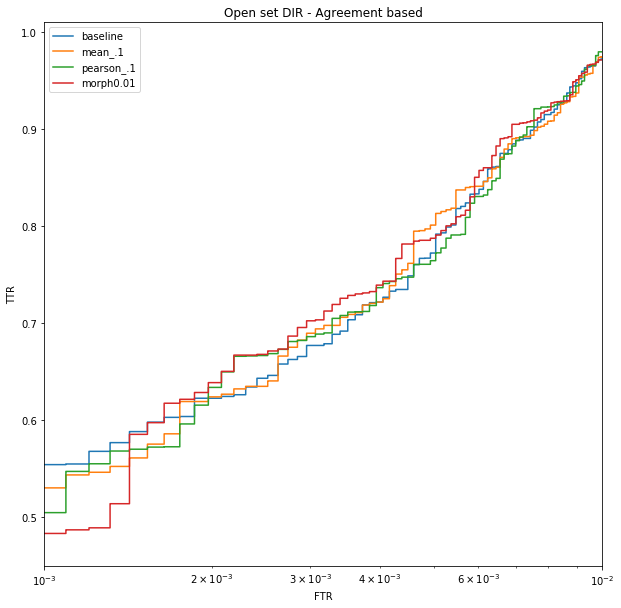

In [146]:
short_list = ['baseline', 'mean_.1', 'pearson_.1', 'morph0.01']
plt.figure(figsize=(10,10))
for name_dir in short_list:
    plt.plot(res_collection[name_dir]['FTRs'], res_collection[name_dir]['TTR'], label=name_dir)
plt.xlabel('FTR')
plt.ylabel('TTR')
plt.ylim([0.45, 1.01])
plt.xscale('log')
plt.xlim([1e-3, 1e-2])
plt.legend()
plt.title('Open set DIR - Agreement based')

Text(0.5,1,'Open set DIR - Agreement based')

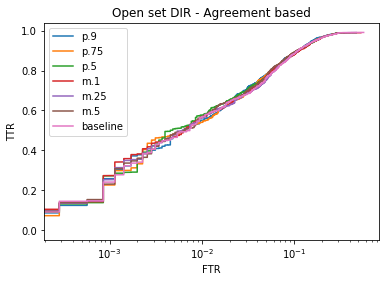

In [158]:
# TODO flip axis?
# TODO add a dash line for cieling?
plt.plot(p9_FTRs, p9_TTR, label='p.9')
plt.plot(p75_FTRs, p75_TTR, label='p.75')
plt.plot(p5_FTRs, p5_TTR, label='p.5')

plt.plot(m1_FTRs, m1_TTR, label='m.1')
plt.plot(m25_FTRs, m25_TTR, label='m.25')
plt.plot(m5_FTRs, m5_TTR, label='m.5')

plt.plot(baseline_FTRs, baseline_TTR, label='baseline')
plt.xlabel('FTR')
plt.ylabel('TTR')
#plt.ylim([0, .4])
plt.xscale('log')
#plt.xlim([1e-4, 1e-2])
plt.legend()
plt.title('Open set DIR - Agreement based')